In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# =========================
# 0) Config
# =========================
# Use the exact name + location from Colab's Files pane
FILE_PATH = "/AugmentedData.product_pricing_full_year_5day (3).csv"

OUTPUT_DIR = os.path.join(os.path.dirname(FILE_PATH), "outlier_full_year_results")
os.makedirs(OUTPUT_DIR, exist_ok=True)


# Choose method: "iqr", "zscore", or "both"
OUTLIER_METHOD = "both"       # robust default
IQR_K = 1.5                   # 1.5 (moderate) or 3.0 (strict)
ZSCORE_THRESHOLD = 3.0        # classic z-score cut


# =========================
# 1) Load and clean
# =========================
def load_data(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    df = df.rename(columns={
        "_id": "_id",
        "product_id": "product_id",
        "date": "date",
        "price": "price"
    })
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df["price"] = pd.to_numeric(df["price"].astype(str).str.replace("$", "", regex=False), errors="coerce")
    df = df.dropna(subset=["product_id", "date", "price"])
    df = df[df["price"] > 0]
    df = df.sort_values(["product_id", "date"]).reset_index(drop=True)
    df["day"] = df["date"].dt.date
    return df

df = load_data(FILE_PATH)
print(f"Records: {len(df)} | Products: {df['product_id'].nunique()} | "
      f"Date range: {df['date'].min()} → {df['date'].max()}")


# =========================
# 2) Per-product static stats
# =========================
def compute_product_stats(g: pd.DataFrame) -> pd.Series:
    median_price = g["price"].median()
    mean_price   = g["price"].mean()
    std_price    = g["price"].std(ddof=1)
    q1, q3       = g["price"].quantile([0.25, 0.75])
    iqr          = q3 - q1
    mad          = np.median(np.abs(g["price"] - median_price))
    min_price    = g["price"].min()
    max_price    = g["price"].max()
    return pd.Series({
        "n_points": len(g),
        "mean_price": mean_price,
        "median_price": median_price,
        "std_price": std_price if np.isfinite(std_price) else np.nan,
        "q1": q1,
        "q3": q3,
        "iqr": iqr,
        "mad": mad,
        "min_price": min_price,
        "max_price": max_price
    })

product_stats = df.groupby("product_id").apply(compute_product_stats).reset_index()
product_stats.to_csv(os.path.join(OUTPUT_DIR, "per_product_stats.csv"), index=False)
print(f"Saved per-product stats → {os.path.join(OUTPUT_DIR, 'per_product_stats.csv')}")


# =========================
# 3) Outlier detection (static baseline)
# =========================
def detect_outliers(df: pd.DataFrame,
                    stats: pd.DataFrame,
                    method: str = "iqr",
                    iqr_k: float = 1.5,
                    z_thresh: float = 3.0) -> pd.DataFrame:
    stats_map = stats.set_index("product_id").to_dict(orient="index")

    out = df.copy()
    # Attach static baselines and extrema
    out["median_price"] = out["product_id"].map(lambda pid: stats_map[pid]["median_price"])
    out["mean_price"]   = out["product_id"].map(lambda pid: stats_map[pid]["mean_price"])
    out["std_price"]    = out["product_id"].map(lambda pid: stats_map[pid]["std_price"])
    out["q1"]           = out["product_id"].map(lambda pid: stats_map[pid]["q1"])
    out["q3"]           = out["product_id"].map(lambda pid: stats_map[pid]["q3"])
    out["iqr"]          = out["product_id"].map(lambda pid: stats_map[pid]["iqr"])
    out["min_price"]    = out["product_id"].map(lambda pid: stats_map[pid]["min_price"])
    out["max_price"]    = out["product_id"].map(lambda pid: stats_map[pid]["max_price"])

    # Boundaries for IQR
    out["iqr_lower"] = out["q1"] - iqr_k * out["iqr"]
    out["iqr_upper"] = out["q3"] + iqr_k * out["iqr"]

    # Z-score (used for method "zscore" or "both")
    out["z_score"] = (out["price"] - out["mean_price"]) / out["std_price"]
    out.loc[~np.isfinite(out["z_score"]), "z_score"] = np.nan

    # Flags
    iqr_flag = (out["price"] < out["iqr_lower"]) | (out["price"] > out["iqr_upper"])
    z_flag   = out["z_score"].abs() > z_thresh

    if method == "iqr":
        out["is_outlier"] = iqr_flag
        out["outlier_method"] = "iqr"
    elif method == "zscore":
        out["is_outlier"] = z_flag
        out["outlier_method"] = "zscore"
    else:  # both
        out["is_outlier"] = iqr_flag | z_flag
        out["outlier_method"] = np.where(iqr_flag & z_flag, "both",
                                  np.where(iqr_flag, "iqr", np.where(z_flag, "zscore", "")))
    return out

flagged = detect_outliers(df, product_stats, method=OUTLIER_METHOD, iqr_k=IQR_K, z_thresh=ZSCORE_THRESHOLD)

outliers = flagged[flagged["is_outlier"]].copy()
out_cols = [
    "_id", "product_id", "date", "day", "price",
    "median_price", "mean_price", "min_price", "max_price",
    "q1", "q3", "iqr", "iqr_lower", "iqr_upper",
    "z_score", "outlier_method"
]
outliers = outliers[out_cols].sort_values(["product_id", "date"])
outliers_path = os.path.join(OUTPUT_DIR, "outliers_static_baseline.csv")
outliers.to_csv(outliers_path, index=False)
print(f"Saved outliers → {outliers_path} (rows: {len(outliers)})")


# =========================
# 4) “Hot dates” analysis (outlier counts only)
# =========================
hot_outlier = (outliers.groupby("day")["product_id"]
               .nunique()
               .reset_index(name="num_products_outlier"))
hot_outlier["share_of_all_products"] = hot_outlier["num_products_outlier"] / df["product_id"].nunique()
hot_outlier = hot_outlier.sort_values("num_products_outlier", ascending=False)
hot_outlier_path = os.path.join(OUTPUT_DIR, "hot_dates_outliers.csv")
hot_outlier.to_csv(hot_outlier_path, index=False)
print(f"Saved hot dates (outliers) → {hot_outlier_path}")


# =========================
# 5) Per-product plots (median baseline; add mean if desired)
# =========================
def plot_product_static_baseline(product_id: str):
    g = flagged[flagged["product_id"] == product_id].sort_values("date")
    if g.empty:
        print(f"No data for product {product_id}")
        return
    med = g["median_price"].iloc[0]
    g_out = g[g["is_outlier"]]

    plt.figure(figsize=(12, 4))
    plt.plot(g["date"], g["price"], label="Price", color="#1f77b4")
    plt.axhline(med, color="#ff7f0e", linestyle="--", label="Median (static baseline)")
    if not g_out.empty:
        plt.scatter(g_out["date"], g_out["price"], color="red", s=30, label="Outliers")
    plt.title(f"Product {product_id} - Price vs Static Median")
    plt.xlabel("Date"); plt.ylabel("Price")
    plt.legend(); plt.tight_layout()
    path = os.path.join(OUTPUT_DIR, f"series_static_{product_id}.png")
    plt.savefig(path, dpi=160); plt.show()
    print(f"Saved product series → {path}")

# Example:
# plot_product_static_baseline(df['product_id'].iloc[0])
# plot_product_static_baseline('your-product-id-here')

Records: 1679 | Products: 23 | Date range: 2025-04-01 00:00:00 → 2026-03-27 00:00:00
Saved per-product stats → /outlier_full_year_results/per_product_stats.csv
Saved outliers → /outlier_full_year_results/outliers_static_baseline.csv (rows: 101)
Saved hot dates (outliers) → /outlier_full_year_results/hot_dates_outliers.csv


/tmp/ipython-input-4018216400.py:74: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_stats = df.groupby("product_id").apply(compute_product_stats).reset_index()


In [ ]:
# =========================
# Logic check: Verify method + thresholds match agreed approach
# =========================

print("Current Outlier Detection Settings:")
print(f"  Method: {OUTLIER_METHOD}")
print(f"  IQR k: {IQR_K}")
print(f"  Z-score threshold: {ZSCORE_THRESHOLD}")

# Show a small sample of flagged outliers
sample_flags = flagged[flagged['is_outlier']].head(5)
print("\nSample flagged outliers:")
display(sample_flags[['product_id', 'date', 'price', 'iqr_lower', 'iqr_upper', 'z_score', 'outlier_method']])


Current Outlier Detection Settings:
  Method: both
  IQR k: 1.5
  Z-score threshold: 3.0

Sample flagged outliers:


,product_id,date,price,iqr_lower,iqr_upper,z_score,outlier_method
50,1f59c631-ca0d-47d9-aac2-8da2dbc1f134,2025-12-07,79.32,58.84,77.64,2.534709,iqr
52,1f59c631-ca0d-47d9-aac2-8da2dbc1f134,2025-12-17,80.66,58.84,77.64,2.850454,iqr
124,3b3e2c46-9899-4f14-8f8f-74ec3a1d31a7,2025-12-12,102.40,72.65,97.45,3.251874,both
130,3b3e2c46-9899-4f14-8f8f-74ec3a1d31a7,2026-01-11,72.19,72.65,97.45,-2.407418,iqr
137,3b3e2c46-9899-4f14-8f8f-74ec3a1d31a7,2026-02-15,71.13,72.65,97.45,-2.605990,iqr


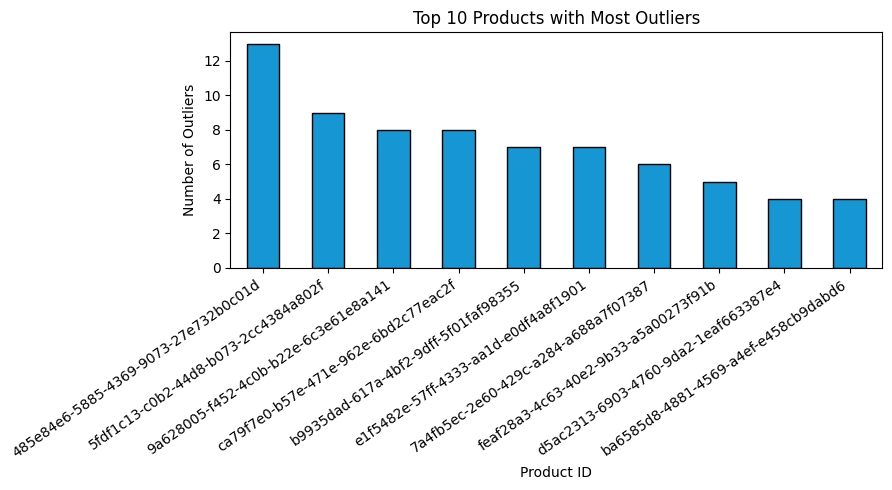

Saved Top Outliers chart -> /outlier_full_year_results/top_outliers.png


In [ ]:
# Top 10 Products with Most Outliers (summary visual)

import matplotlib.pyplot as plt

# Count outliers per product (booleans summed -> counts)
outlier_counts = (
    flagged.groupby('product_id')['is_outlier']
    .sum()
    .sort_values(ascending=False)
)

# Handle cases with <10 products gracefully
top_n = min(10, len(outlier_counts))

plt.figure(figsize=(9, 5))
ax = outlier_counts.head(top_n).plot(kind='bar', color='#1696d2', edgecolor='black')
plt.title('Top {} Products with Most Outliers'.format(top_n))
plt.ylabel('Number of Outliers')
plt.xlabel('Product ID')
plt.xticks(rotation=35, ha='right')
plt.tight_layout()

# Save and show
top10_path = os.path.join(OUTPUT_DIR, 'top_outliers.png')
plt.savefig(top10_path, dpi=300, bbox_inches='tight')
plt.show()

print("Saved Top Outliers chart ->", top10_path)


In [ ]:
# === Corrected re-export from CSV (fix counts + UUID labels) ===
import pandas as pd
import matplotlib.pyplot as plt

csv_path = os.path.join(OUTPUT_DIR, "outliers_static_baseline.csv")
df = pd.read_csv(csv_path)

counts = (
    df.groupby("product_id").size()
      .sort_values(ascending=False)
      .head(10)
)

plt.figure(figsize=(10, 5))
bars = plt.bar(counts.index, counts.values, color="#4C78A8", edgecolor="black")
plt.title("Top 10 Products with Most Outliers")
plt.ylabel("Number of Outliers")
plt.xticks(rotation=35, ha="right")
plt.tight_layout()

fixed_path = os.path.join(OUTPUT_DIR, "top_outliers.png")
plt.savefig(fixed_path, dpi=300, bbox_inches="tight")
plt.close()

print("Corrected Top Outliers chart ->", fixed_path)


Corrected Top Outliers chart -> /outlier_full_year_results/top_outliers.png


In [ ]:
# create PDF for each product's price trend
from matplotlib.backends.backend_pdf import PdfPages

pdf_path = os.path.join(OUTPUT_DIR, "product_trends.pdf")
with PdfPages(pdf_path) as pdf:
    for pid in df["product_id"].unique():
        g = flagged[flagged["product_id"] == pid].sort_values("date")
        if g.empty:
            continue

        med  = g["median_price"].iloc[0]
        mean = g["mean_price"].iloc[0]
        q1   = g["q1"].iloc[0]
        q3   = g["q3"].iloc[0]

        fig, ax = plt.subplots(figsize=(12, 4))
        ax.plot(g["date"], g["price"], color="#1f77b4", linewidth=1.5, label="Price")
        ax.scatter(g["date"], g["price"], color="#1f77b4", s=10, alpha=0.6)

        ax.axhline(med,  color="#ff7f0e", linestyle="--", linewidth=1.2, label="Median")
        ax.axhline(mean, color="#2ca02c", linestyle="-.",  linewidth=1.2, label="Mean")
        ax.fill_between([g["date"].min(), g["date"].max()], q1, q3, color="#ff7f0e", alpha=0.15, label="IQR band")

        out = g[g["is_outlier"]]
        if not out.empty:
            ax.scatter(out["date"], out["price"], color="red", s=30, zorder=3, label="Outlier")

        ax.set_title(f"Product {pid} — Price vs Static Baseline")
        ax.set_xlabel("Date"); ax.set_ylabel("Price")
        ax.legend(loc="best")
        fig.autofmt_xdate()
        fig.tight_layout()

        pdf.savefig(fig)
        plt.close(fig)

print(f"Saved multi-page PDF: {pdf_path}")

Saved multi-page PDF: /outlier_full_year_results/product_trends.pdf
